<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/africa_bayes_svi_hmc_pyro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian linear regression in Pyro (for Africa GDP dataset)

We compare (stochastic) variational inference with HMC for Bayesian linear regression. We use the example from sec 8.1 of  [Statistical Rethinking ed 2](https://xcelab.net/rm/statistical-rethinking/). 
The code is modified from https://pyro.ai/examples/bayesian_regression.html and 
https://pyro.ai/examples/bayesian_regression_ii.html. 

For a NumPyro version (that uses Laplace approximation instead of SVI/ HMC), see https://fehiepsi.github.io/rethinking-numpyro/08-conditional-manatees.html.

In [1]:
#!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro

!pip3 install pyro-ppl 

     |████████████████████████████████| 634kB 30.4MB/s 


In [2]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
from pyro.nn import PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import Predictive
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import MCMC, NUTS
pyro.set_rng_seed(1)

from torch import nn
from pyro.nn import PyroModule

# Data

The dataset has 3 variables: $A$ (whether a country is in Africa or not), $R$ (its terrain ruggedness), and $G$ (the log GDP per capita in 2000). We want to preict $G$ from $A$, $R$, and $A \times R$. The response variable is very skewed, so we log transform it.  

In [3]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

# Dataset: Add a feature to capture the interaction between "cont_africa" and "rugged"
# ceofficeints are:  beta_a, beta_r, beta_ar
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]
data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values,
                        dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


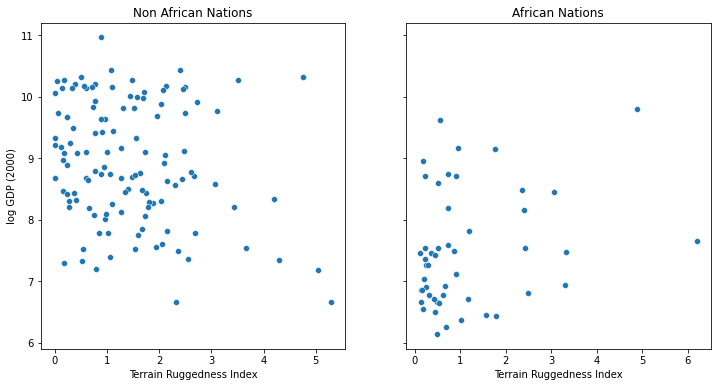

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(non_african_nations["rugged"],
            non_african_nations["rgdppc_2000"],
            ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(african_nations["rugged"],
                african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

# Ordinary least squares

We define the linear model as a simple neural network with no hidden layers. We fit it by using maximum likelihood, optimized by (full batch) gradient descent, as is standard for DNNs.

In [ ]:
pyro.set_rng_seed(1)
#linear_reg_model = PyroModule[nn.Linear](3, 1)
linear_reg_model = nn.Linear(3, 1)

In [ ]:
print(type(linear_reg_model))

<class 'torch.nn.modules.linear.Linear'>


In [ ]:


# Define loss and optimize
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 1500

def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
    if (j + 1) % 200 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))



[iteration 0200] loss: 833.7546
[iteration 0400] loss: 296.0484
[iteration 0600] loss: 166.3493
[iteration 0800] loss: 149.2020
[iteration 1000] loss: 147.9347
[iteration 1200] loss: 147.8827
[iteration 1400] loss: 147.8815


In [ ]:

# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

Learned parameters:
weight [[-1.9478593  -0.20278622  0.39330277]]
bias [9.22308]


In [ ]:
mle_weights = linear_reg_model.weight.data.numpy().squeeze()
print(mle_weights)
mle_bias = linear_reg_model.bias.data.numpy().squeeze()
print(mle_bias)
mle_params = [mle_weights, mle_bias]
print(mle_params)

[-1.9478593  -0.20278622  0.39330277]
9.22308
[array([-1.9478593 , -0.20278622,  0.39330277], dtype=float32), array(9.22308, dtype=float32)]


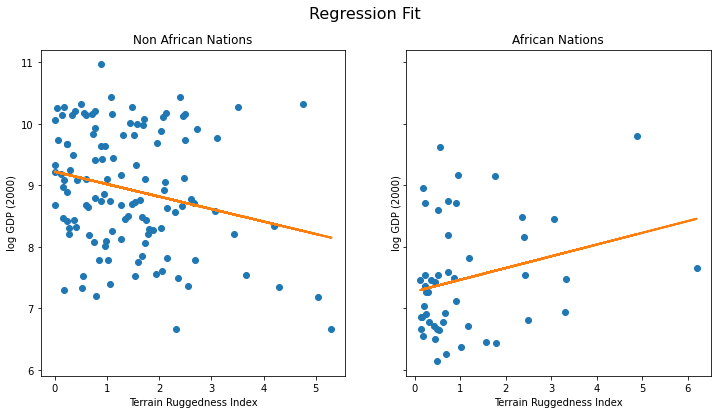

In [ ]:
fit = df.copy()
fit["mean"] = linear_reg_model(x_data).detach().cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = fit[fit["cont_africa"] == 1]
non_african_nations = fit[fit["cont_africa"] == 0]
fig.suptitle("Regression Fit", fontsize=16)
ax[0].plot(non_african_nations["rugged"], non_african_nations["rgdppc_2000"], "o")
ax[0].plot(non_african_nations["rugged"], non_african_nations["mean"], linewidth=2)
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
ax[1].plot(african_nations["rugged"], african_nations["rgdppc_2000"], "o")
ax[1].plot(african_nations["rugged"], african_nations["mean"], linewidth=2)
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

# Bayesian model

To make a Bayesian version of the linear neural network, we need to use a Pyro module instead of a torch.nn.module. This lets us replace torch tensors containg the parameters with random variables, defined by PyroSample commands. We also specify the likelihood function by using a plate over the multiple observations.

In [4]:
# https://forum.pyro.ai/t/extra-dim-added-to-some-variables-when-using-predictive/2904/6

class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        N = x.shape[0]
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x) # (N,1)
        mean_vec = mean.squeeze(-1) # (N)
        with pyro.plate("data", x.shape[0]):   
          mu = pyro.deterministic("mu", mean_vec) # (N)       
          obs = pyro.sample("obs", dist.Normal(mean_vec, sigma), obs=y)
        return mean_vec

In [5]:
# quick test of the model shapes

model = BayesianRegression(3, 1)
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=10, warmup_steps=1)
mcmc.run(x_data, y_data)

predictive = Predictive(model, mcmc.get_samples(), return_sites=("obs", "mu", "_RETURN"))
hmc_samples_pred = predictive(x_data)
print(hmc_samples_pred.keys())
print(hmc_samples_pred['obs'].shape) # [S,170]
print(hmc_samples_pred['mu'].shape) # [S,170]
print(hmc_samples_pred['_RETURN'].shape) # [S,170]

Sample: 100%|██████████| 11/11 [00:00, 30.77it/s, step size=1.25e-01, acc. prob=0.478]

dict_keys(['obs', 'mu', '_RETURN'])
torch.Size([10, 170])
torch.Size([10, 170])
torch.Size([10, 170])


# Utilities

## Summarize posterior 

In [22]:
def summary_np_scalars(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

def summary_torch(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats



In [23]:
def plot_param_post_helper(samples, label, axs):
  ax = axs[0]
  sns.distplot(samples['linear.bias'], ax=ax, label=label)
  ax.set_title('bias')
  for i in range(0,3):
    ax = axs[i+1]
    sns.distplot(samples['linear.weight'][:,0,i], ax=ax, label=label)
    ax.set_title(f'weight {i}')
 
def plot_param_post(samples_list, label_list):
  fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
  axs = axs.reshape(-1)
  fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
  n_methods = len(samples_list)
  for i in range(n_methods):
    plot_param_post_helper(samples_list[i], label_list[i], axs)
  ax = axs[-1]
  handles, labels = ax.get_legend_handles_labels()
  fig.legend(handles, labels, loc='upper right');

def plot_param_post2d_helper(samples, label, axs, shade=True):
  ba = samples["linear.weight"][:,0,0] # africa indicator
  br = samples["linear.weight"][:,0,1] # ruggedness
  bar = samples["linear.weight"][:,0,2] # africa*ruggedness
  sns.kdeplot(ba, br, ax=axs[0], shade=shade, label=label)
  axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
  sns.kdeplot(br, bar, ax=axs[1], shade=shade, label=label)
  axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))

def plot_param_post2d(samples_list, label_list):
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
  axs = axs.reshape(-1)
  fig.suptitle("Cross-section of the Posterior Distribution", fontsize=16)
  n_methods = len(samples_list)
  shades = [False, True] # first method is contour, second is shaded
  for i in range(n_methods):
    plot_param_post2d_helper(samples_list[i], label_list[i], axs, shades[i])
  ax = axs[-1]
  handles, labels = ax.get_legend_handles_labels()
  fig.legend(handles, labels, loc='upper right');
  #fig.legend() 

## Plot posterior predictions

In [ ]:
def plot_pred_helper(predictions, africa, ax):
  nations = predictions[predictions["cont_africa"] == africa]
  nations = nations.sort_values(by=["rugged"])
  ax.plot(nations["rugged"], nations["mu_mean"], color="k")
  ax.plot(nations["rugged"], nations["true_gdp"], "o")
  # uncertainty about mean
  ax.fill_between(nations["rugged"], nations["mu_perc_5"], nations["mu_perc_95"],
                alpha=0.2, color="k")
  # uncertainty about observations
  ax.fill_between(nations["rugged"], nations["y_perc_5"], nations["y_perc_95"],
                   alpha=0.15, color="k")
  

  ax.set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)")
  return ax

def make_post_pred_df(samples_pred):
  pred_summary = summary_torch(samples_pred)
  #mu = pred_summary["_RETURN"]
  mu = pred_summary["mu"]
  y = pred_summary["obs"]
  predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
  })
  return predictions

def plot_pred(samples_pred):
  predictions = make_post_pred_df(samples_pred)
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
  plot_pred_helper(predictions, 0, axs[0])
  axs[0].set_title('Non-African nations')
  plot_pred_helper(predictions, 1, axs[1])
  axs[1].set_title('African nations')

# HMC inference

In [25]:

pyro.set_rng_seed(1)


model = BayesianRegression(3, 1)
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=100)
mcmc.run(x_data, y_data)


Sample: 100%|██████████| 600/600 [00:16, 35.45it/s, step size=3.09e-01, acc. prob=0.920]


In [26]:
mcmc.diagnostics()

{'acceptance rate': {'chain 0': 0.996},
 'divergences': {'chain 0': []},
 'linear.bias': OrderedDict([('n_eff', tensor([191.6499])),
              ('r_hat', tensor([1.0053]))]),
 'linear.weight': OrderedDict([('n_eff',
               tensor([[218.1089, 206.9249, 245.8107]])),
              ('r_hat', tensor([[1.0036, 0.9992, 1.0066]]))]),
 'sigma': OrderedDict([('n_eff', tensor(252.5428)),
              ('r_hat', tensor(1.0023))])}

In [27]:

print(mcmc.get_samples().keys())
print(mcmc.get_samples()['linear.weight'].shape)
print(mcmc.get_samples()['linear.bias'].shape)

dict_keys(['sigma', 'linear.weight', 'linear.bias'])
torch.Size([500, 1, 3])
torch.Size([500, 1])


In [28]:
hmc_samples_torch = mcmc.get_samples()
summary_torch(hmc_samples_torch)

{'linear.bias': {'5%': tensor([8.9465]),
  '95%': tensor([9.4065]),
  'mean': tensor([9.1725]),
  'std': tensor([0.1389])},
 'linear.weight': {'5%': tensor([[-2.2516, -0.3109,  0.1182]]),
  '95%': tensor([[-1.4847, -0.0540,  0.5486]]),
  'mean': tensor([[-1.8338, -0.1782,  0.3345]]),
  'std': tensor([[0.2229, 0.0766, 0.1303]])},
 'sigma': {'5%': tensor(0.8824),
  '95%': tensor(1.0609),
  'mean': tensor(0.9592),
  'std': tensor(0.0542)}}

## Parameter posterior

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

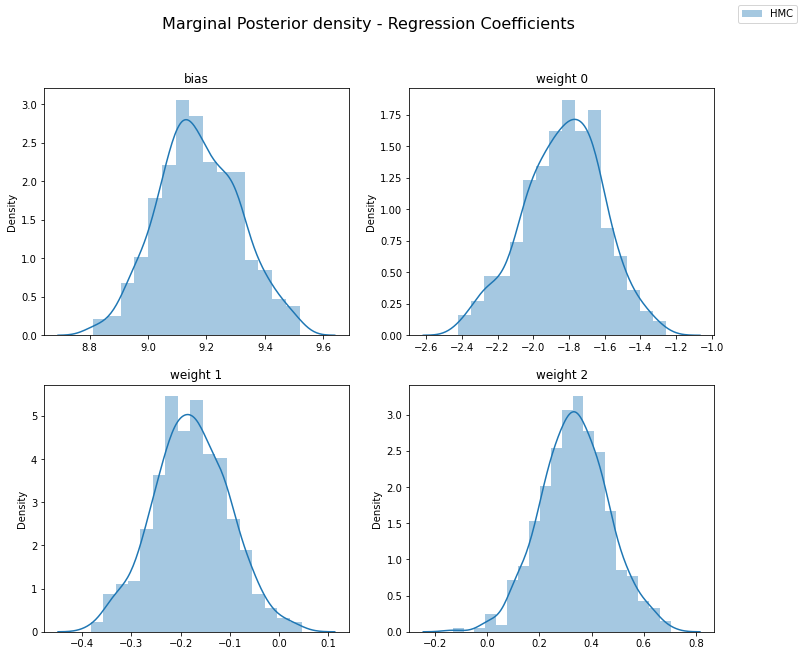

In [30]:
hmc_samples_params = {k: v.detach().cpu().numpy() for k, v in hmc_samples_torch.items()}
plot_param_post([hmc_samples_params], ['HMC'])


In [ ]:
hmc_samples_params['linear.weight'].shape

(1000, 1, 3)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


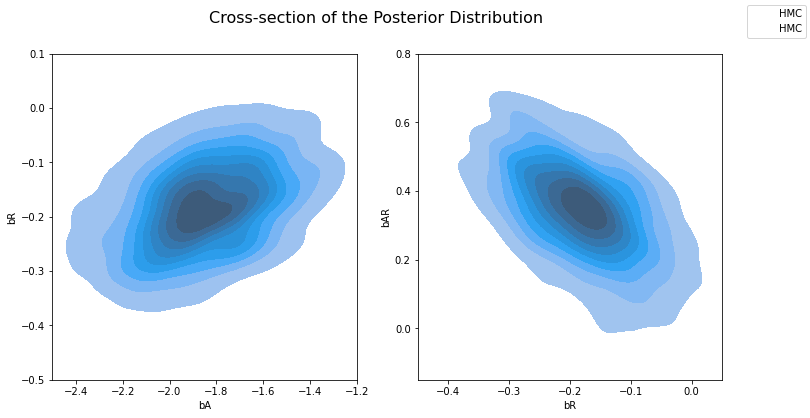

In [ ]:
plot_param_post2d([hmc_samples_params], ['HMC'])

## Predictive posterior

In [ ]:
#predictive = Predictive(model, mcmc.get_samples(), return_sites=("obs", "_RETURN"))
predictive = Predictive(model, mcmc.get_samples(), return_sites=("obs", "mu", "_RETURN"))
hmc_samples_pred = predictive(x_data)
print(hmc_samples_pred.keys())
print(hmc_samples_pred['obs'].shape)
print(hmc_samples_pred['mu'].shape)
print(hmc_samples_pred['_RETURN'].shape)

dict_keys(['obs', 'mu', '_RETURN'])
torch.Size([500, 170])
torch.Size([500, 170])
torch.Size([500, 170])


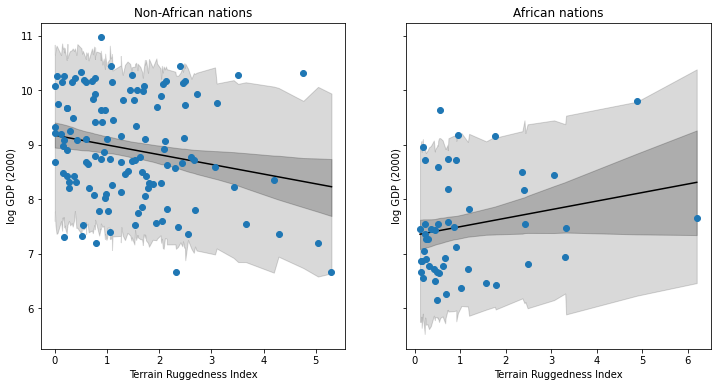

In [ ]:

plot_pred(hmc_samples_pred)
plt.savefig('linreg_africa_post_pred_hmc.pdf', dpi=300)

# Diagonal Gaussian variational posterior

## Fit

In [6]:
pyro.set_rng_seed(1)

model = BayesianRegression(3, 1)
guide = AutoDiagonalNormal(model)

adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [7]:
pyro.clear_param_store()
num_iterations = 1000
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 4.6074
[iteration 0101] loss: 3.1127
[iteration 0201] loss: 2.5499
[iteration 0301] loss: 1.8550
[iteration 0401] loss: 1.4601
[iteration 0501] loss: 1.4473
[iteration 0601] loss: 1.4725
[iteration 0701] loss: 1.4654
[iteration 0801] loss: 1.4677
[iteration 0901] loss: 1.4628


## Parameter posterior

In [17]:
post = guide.get_posterior()
nsamples = 800
samples = post.sample(sample_shape=(nsamples,))
print(samples.shape) # [800,5]
print(torch.mean(samples,dim=0)) # transform(sigma), weights 0:2, bias 


torch.Size([800, 5])
tensor([-2.2915, -1.8643, -0.1935,  0.3348,  9.1667])


In [18]:
# derive posterior quantiles for model parameters from the variational parameters
# note that we transform to the original parameter domain (eg sigma is in [0,10])
quant = guide.quantiles([0.5])
print(quant)

{'sigma': [tensor(0.9182)], 'linear.weight': [tensor([[-1.8635, -0.1926,  0.3305]])], 'linear.bias': [tensor([9.1682])]}


In [19]:
predictive = Predictive(model, guide=guide, num_samples=800, 
                        return_sites=("sigma", "linear.bias", "linear.weight"))
diag_samples_pred = predictive(x_data, y_data)
print(diag_samples_pred.keys())
print(diag_samples_pred['sigma'].shape)
print(diag_samples_pred['linear.weight'].shape)
print(diag_samples_pred['linear.bias'].shape)

print(torch.mean(diag_samples_pred['sigma']))
print(torch.mean(diag_samples_pred['linear.weight'], dim=0))
print(torch.mean(diag_samples_pred['linear.bias']))

dict_keys(['sigma', 'linear.weight', 'linear.bias'])
torch.Size([800, 1])
torch.Size([800, 1, 1, 3])
torch.Size([800, 1, 1])
tensor(0.9198)
tensor([[[-1.8608, -0.1920,  0.3269]]])
tensor(9.1698)


(800, 1, 3)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

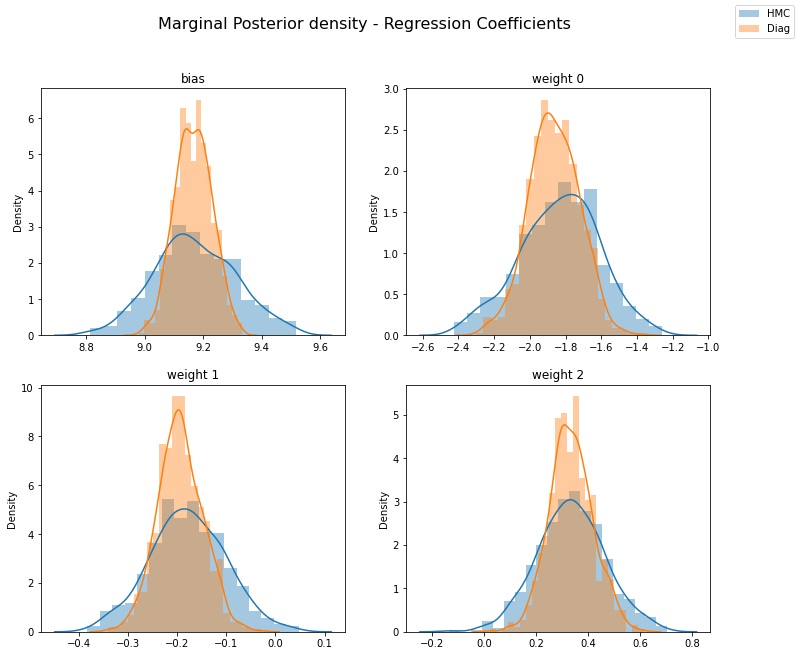

In [31]:
weights = np.reshape(samples[:,1:4].detach().cpu().numpy(), (-1, 1, 3))
bias = samples[:,4].detach().cpu().numpy()

diag_samples_params = {'linear.weight': weights, 'linear.bias': bias}
print(diag_samples_params['linear.weight'].shape)

plot_param_post([hmc_samples_params, diag_samples_params, ], ['HMC', 'Diag'])
plt.savefig('linreg_africa_post_marginals_hmc_diag.pdf', dpi=300)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

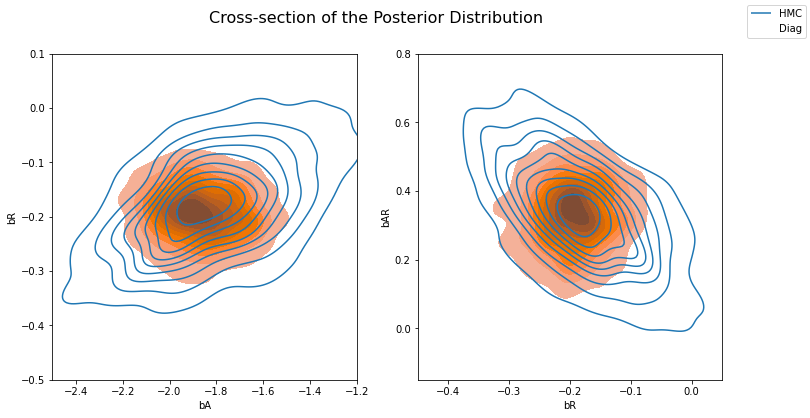

In [ ]:
plot_param_post2d([hmc_samples_params, diag_samples_params], ['HMC', 'Diag'])
plt.savefig('linreg_africa_post_2d_hmc_diag.pdf', dpi=300)

## Posterior predictive

We extract posterior predictive distribution for obs, and the return value of the model (which is the mean prediction).

In [ ]:
predictive = Predictive(model, guide=guide, num_samples=800, return_sites=("obs", "_RETURN"))
diag_samples_pred = predictive(x_data)
print(diag_samples_pred.keys())
print(diag_samples_pred['_RETURN'].shape)

dict_keys(['obs', '_RETURN'])
torch.Size([800, 170])


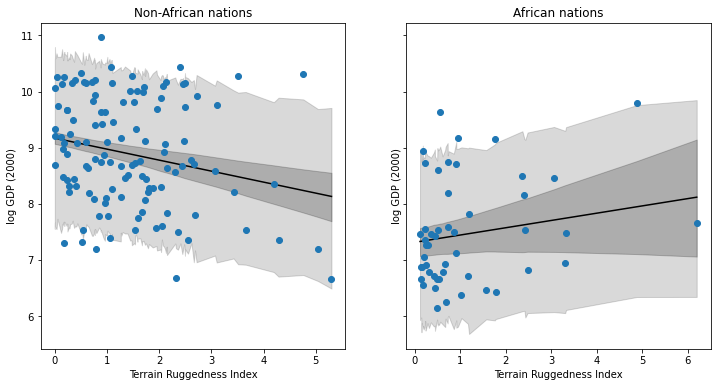

In [ ]:

plot_pred(diag_samples_pred)

# Full Gaussian variational posterior

## Fit

In [ ]:
pyro.set_rng_seed(1)

model = BayesianRegression(3, 1)

from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean
guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)


adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [ ]:
pyro.clear_param_store()
num_iterations = 1000
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 4.1448
[iteration 0101] loss: 3.0792
[iteration 0201] loss: 2.2105
[iteration 0301] loss: 1.6650
[iteration 0401] loss: 1.4696
[iteration 0501] loss: 1.4720
[iteration 0601] loss: 1.4739
[iteration 0701] loss: 1.4870
[iteration 0801] loss: 1.5161
[iteration 0901] loss: 1.4809


## Parameter posterior

In [ ]:
post = guide.get_posterior()
nsamples = 800
samples = post.sample(sample_shape=(nsamples,))
print(samples.shape) # [800,5]
print(torch.mean(samples,dim=0)) # transform(sigma), weights 0:2, bias 

torch.Size([800, 5])
tensor([-2.2520, -1.9146, -0.1860,  0.3116,  9.1130])


In [ ]:
weights = np.reshape(samples[:,1:4].detach().cpu().numpy(), (-1, 1, 3))
bias = samples[:,4].detach().cpu().numpy()

full_samples_params = {'linear.weight': weights, 'linear.bias': bias}
print(full_samples_params['linear.weight'].shape)

(800, 1, 3)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

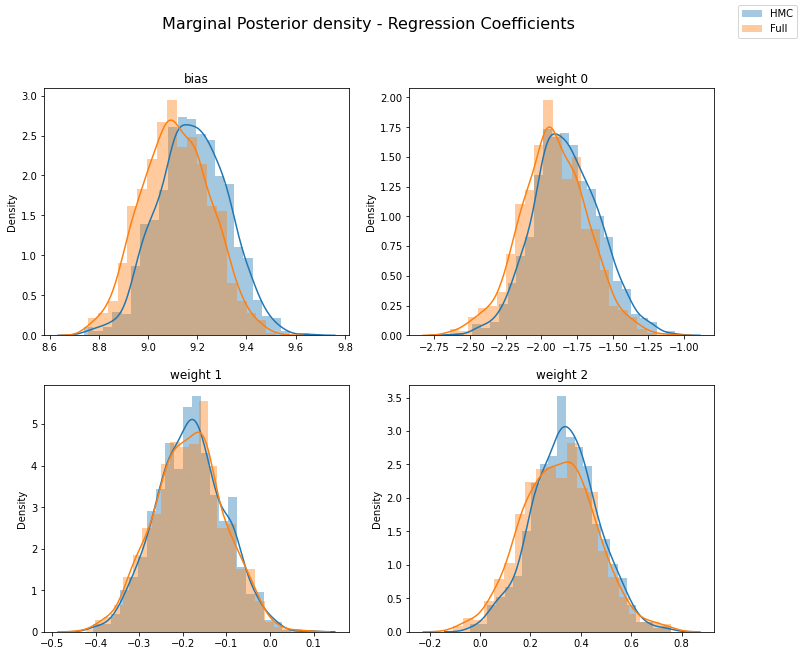

In [ ]:
plot_param_post([hmc_samples_params, full_samples_params, ], ['HMC', 'Full'])
plt.savefig('linreg_africa_post_marginals_hmc_full.pdf', dpi=300)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

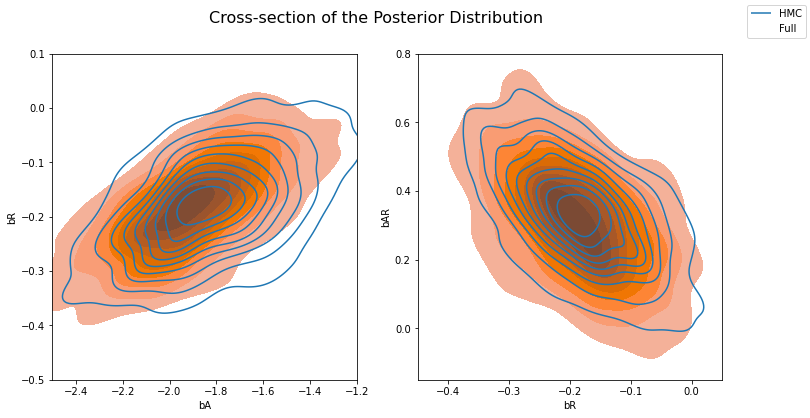

In [ ]:
plot_param_post2d([hmc_samples_params, full_samples_params], ['HMC', 'Full'])
plt.savefig('linreg_africa_post_2d_hmc_full.pdf', dpi=300)

## Predictive posterior

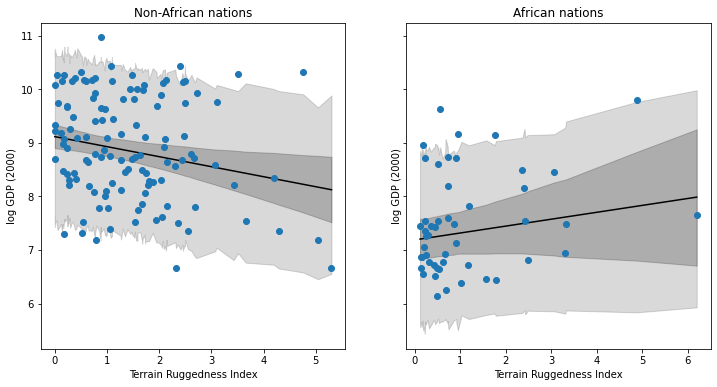

In [ ]:
predictive = Predictive(model, guide=guide, num_samples=800, return_sites=("obs", "_RETURN"))
full_samples_pred = predictive(x_data)
plot_pred(full_samples_pred)
